# Natural Language Processing with Disaster Tweets


## The Problem and Data

The problem that this notebook is trying to solve is figuring out if a real-time tweet is talking about a disaster or not. Using Natural Language Processing (NLP) to classify these tweets and learn what really is disaster tweet and what isn't.

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras.backend as K
import keras_nlp
import seaborn as sns

from collections import Counter
from glob import glob
from skimage.io import imread
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential


import nltk
nltk.download('stopwords')

from nltk.corpus import  stopwords

[nltk_data] Downloading package stopwords to /home/basilp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I was fortunate enough to use my GPU to help accelerate training via tensorflow

In [12]:
# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EDA
Loading the data

In [101]:
train_data_df = pd.read_csv("train.csv")
test_data_df = pd.read_csv("test.csv")
sample_data_df = pd.read_csv("sample_submission.csv")

Data dimensions and size

In [4]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
sample_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


## Empty Data!
We're not removing rows with empty data as keyword and location aren't really the main focus - simply if a set amount of text is a disaster or not.

In [17]:
print(train_data_df.isna().sum())
print(test_data_df.isna().sum())
print(sample_data_df.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64
id        0
target    0
dtype: int64


In [18]:
train_data_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
train_data_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


What does the text look like?

In [102]:
for x in range(20):
    print(train_data_df["text"][x])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

### Text Preprocessing

We're going to do some clean up like removing hashtags, lowercasing everything, numbers, and all stop-words.

In [103]:
def preprocess_text(text):
    # Remove http links
    text = re.sub(r'https?://\S+', '', text)
    # Remove hashtags
    text = text.replace("#", "")
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Lowercase everything
    text = text.lower()
    # Remove stop-words
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [104]:
train_data_df["text"] = train_data_df["text"].apply(preprocess_text)

In [105]:
for x in range(20):
    print(train_data_df["text"][x])

deeds reason earthquake may allah forgive us
forest fire near la ronge sask canada
residents asked shelter place notified officers evacuation shelter place orders expected
 people receive wildfires evacuation orders california
got sent photo ruby alaska smoke wildfires pours school
rockyfire update  california hwy closed directions due lake county fire  cafire wildfires
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
top hill see fire woods
theres emergency evacuation happening building across street
afraid tornado coming area
three people died heat wave far
haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding
raining flooding florida tampabay tampa days lost count
flood bago myanmar arrived bago
damage school bus multi car crash breaking
whats man
love fruits
summer lovely
car fast
goooooooaaaaaal


### Visualizations

In [94]:
target_counts = train_data_df["target"].value_counts()


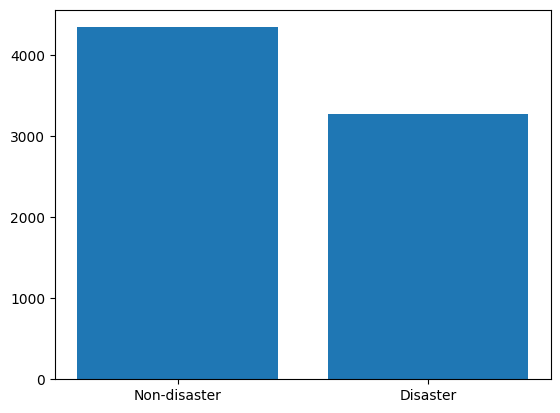

<Figure size 500x500 with 0 Axes>

In [106]:
plt.bar(x=["Non-disaster", "Disaster"], height=target_counts)
plt.figure(figsize=(5,5))
plt.show()

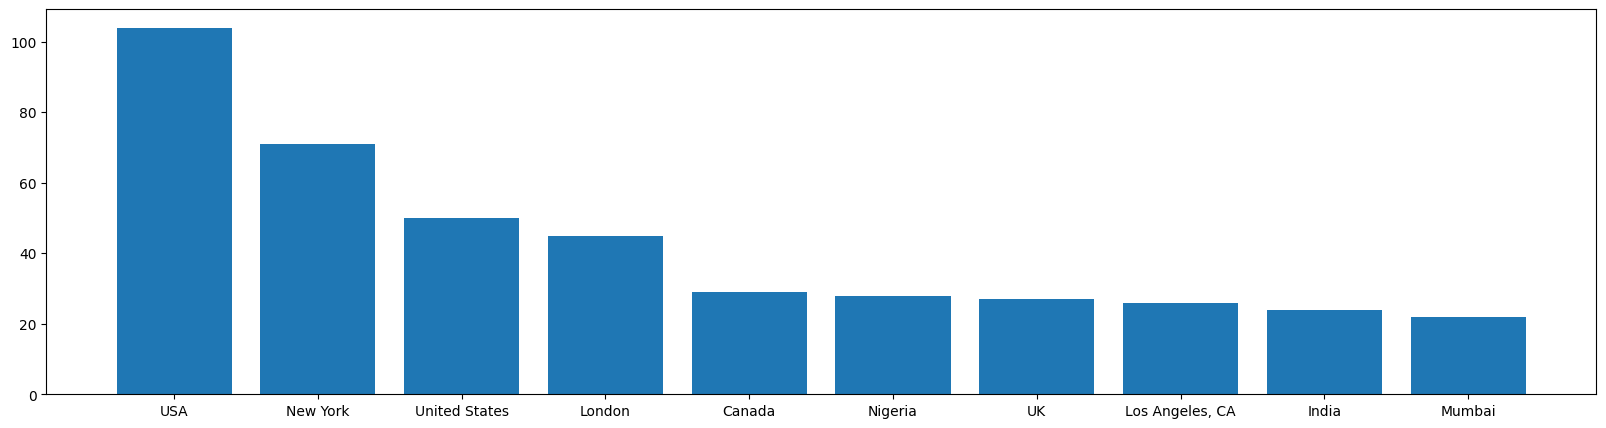

In [107]:
# Top ten locations
location_counts = train_data_df["location"].value_counts()[:10]
plt.figure(figsize=(20,5))
plt.bar(x=location_counts.index, height=location_counts)
plt.show()

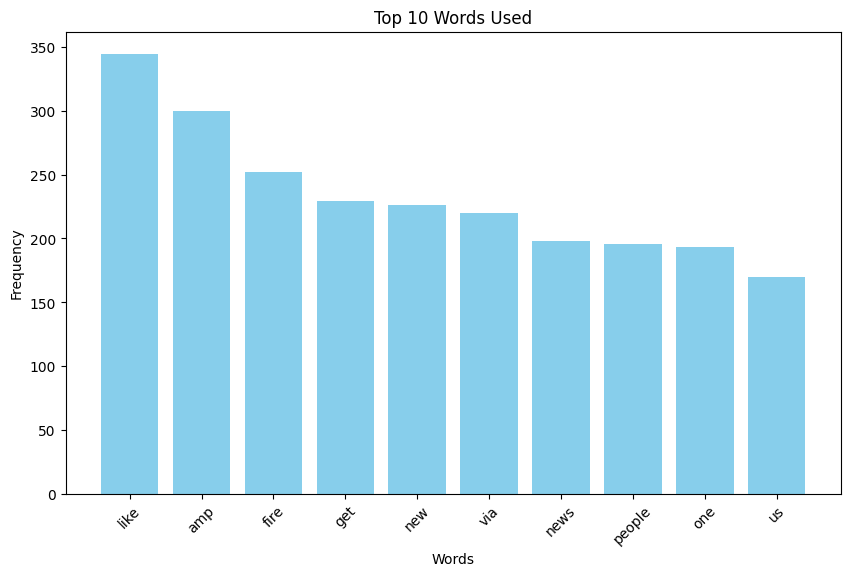

In [109]:
# Top 10 words
all_text = " ".join(train_data_df["text"])
word_counts = Counter(all_text.split())
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Used')
plt.xticks(rotation=45)
plt.show()

# References
Keras. (n.d.). Getting started with Keras Hub. Retrieved April 15, 2025, from https://keras.io/keras_hub/getting_started/

Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2020). DistilBERT, a distilled version of BERT: Smaller, faster, cheaper and lighter. arXiv. https://doi.org/10.48550/arXiv.1910.01108